In [238]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn as sk

from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.linear_model import ElasticNet, ElasticNetCV, LassoCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

In [239]:
gr = pd.read_csv("gameResults.csv")
tg = pd.read_csv("teamGeography.csv")
tr = pd.read_csv("teamRecords.csv")

In [240]:
print("Game Results Data:")
print(gr.head(10))
print("Game Results Description:")
print(gr.describe(include="all"))
print("Columns in Game Results:")
print(list(gr.columns))

Game Results Data:
          id  season  ...  away_postgame_elo excitement_index
0  401282714    2021  ...             1484.0         5.485981
1  401286187    2021  ...             1122.0         1.535556
2  401309833    2021  ...             1378.0         1.391185
3  401282049    2021  ...             1301.0         1.702420
4  401310693    2021  ...                NaN              NaN
5  401282050    2021  ...                NaN         2.131612
6  401309540    2021  ...                NaN         2.026239
7  401282051    2021  ...                NaN         1.825486
8  401328545    2021  ...                NaN              NaN
9  401309542    2021  ...                NaN         1.153753

[10 rows x 34 columns]
Game Results Description:
                  id  season  ...  away_postgame_elo excitement_index
count   8.910000e+02   891.0  ...         735.000000       811.000000
unique           NaN     NaN  ...                NaN              NaN
top              NaN     NaN  ...      

In [241]:
print("Team Records Data:")
print(tr.head(10))
print("Team Records Description:")
print(tr.describe(include="all"))
print("Columns in Team Records:")
print(list(tr.columns))

Team Records Data:
   year               team  ... awayGames.losses awayGames.ties
0  2021          Air Force  ...                0              0
1  2021              Akron  ...                5              0
2  2021            Alabama  ...                1              0
3  2021  Appalachian State  ...                3              0
4  2021            Arizona  ...                5              0
5  2021      Arizona State  ...                3              0
6  2021           Arkansas  ...                3              0
7  2021     Arkansas State  ...                5              0
8  2021               Army  ...                2              0
9  2021             Auburn  ...                3              0

[10 rows x 21 columns]
Team Records Description:
          year              team  ... awayGames.losses awayGames.ties
count    130.0               130  ...       130.000000          130.0
unique     NaN               130  ...              NaN            NaN
top        NaN  M

In [242]:
print("Team Geography Data:")
print(tg.head(10))
print("Team Geography Description:")
print(tg.describe(include="all"))
print("Columns in Team Geography:")
print(list(tg.columns))

Team Geography Data:
              school  location.elevation     location.city location.state
0  Abilene Christian                 NaN               NaN            NaN
1        Adams State                 NaN               NaN            NaN
2             Adrian                 NaN               NaN            NaN
3          Air Force         2024.875732  Colorado Springs             CO
4              Akron          321.287506             Akron             OH
5            Alabama           70.051361        Tuscaloosa             AL
6        Alabama A&M                 NaN               NaN            NaN
7      Alabama State           75.102104        Montgomery             AL
8             Albany           70.100000            Albany             NY
9  Albany State (GA)                 NaN               NaN            NaN
Team Geography Description:
               school  location.elevation location.city location.state
count            1729        2.120000e+02           212           

In [243]:
unusedGrCols = ['id', "season", "week", "season_type", "start_date", "start_time_tbd", "neutral_site", "conference_game", "attendance", "venue_id", "venue", "home_id", "home_conference"]
unusedGrCols += ["home_post_win_prob", "home_pregame_elo", "home_postgame_elo", "away_id", "away_conference", "away_post_win_prob", "away_pregame_elo", "away_postgame_elo", "excitement_index"]
unusedGrCols += ["home_line_scores[0]", "home_line_scores[1]", "home_line_scores[2]", "home_line_scores[3]", "away_line_scores[0]", "away_line_scores[1]", "away_line_scores[2]"]
unusedGrCols += ["away_line_scores[3]"]
for id in unusedGrCols:
  gr.drop(id, axis=1, inplace=True)
print(gr.head(10))

               home_team  home_points               away_team  away_points
0               Illinois         30.0                Nebraska         22.0
1           Fresno State         45.0             Connecticut          0.0
2                   UCLA         44.0                 Hawai'i         10.0
3       New Mexico State          3.0                    UTEP         30.0
4         San José State         45.0           Southern Utah         14.0
5     Jacksonville State          0.0                     UAB         31.0
6             Ball State         31.0        Western Illinois         21.0
7  Florida International         54.0  Long Island University         10.0
8       Coastal Carolina         52.0             The Citadel         14.0
9                Buffalo         69.0                  Wagner          7.0


In [244]:
unusedTrCols = ["year", "expectedWins", "conferenceGames.games", "conferenceGames.wins", "conferenceGames.losses", "conferenceGames.ties", "homeGames.games"]
unusedTrCols += ["homeGames.wins", "homeGames.losses", "homeGames.ties", "awayGames.games", "awayGames.wins", "awayGames.losses", "awayGames.ties", "total.ties"]
for id in unusedTrCols:
  tr.drop(id, axis=1, inplace=True)
print(tr.head(10))

                team        conference  ... total.wins  total.losses
0          Air Force     Mountain West  ...          9             3
1              Akron      Mid-American  ...          2            10
2            Alabama               SEC  ...         12             1
3  Appalachian State          Sun Belt  ...         10             4
4            Arizona            Pac-12  ...          1            11
5      Arizona State            Pac-12  ...          8             4
6           Arkansas               SEC  ...          8             4
7     Arkansas State          Sun Belt  ...          2            10
8               Army  FBS Independents  ...          8             4
9             Auburn               SEC  ...          6             6

[10 rows x 6 columns]


In [245]:
# conversion functions for string data types
def convert_conference(conf):
  conf_dict = {
        'American' : 1,
        'ACC' : 2,
        'Big 12' : 3,
        'Big Ten' : 4,
        'Conference USA' : 5,
        'FBS Independents' : 6,
        'Mid-American' : 7,
        'Mountain West' : 8,
        'Pac-12' : 9,
        'SEC' : 10,
        'Sun Belt' : 11
    }
  try:
    try:
      return conf_dict.get(conf.array[0], 0)
    except:
      return conf_dict.get(conf, 0)
  except:
    return 0

def convert_division(div):
  div_dict = {
        'North' : 1,
        'South' : 2,
        'East' : 3,
        'West' : 4,
        'Atlantic' : 5,
        'Mountain' : 6,
        'Coastal' : 7
    }
  try:
    try:
      return div_dict.get(div.array[0], 0)
    except:
      return div_dict.get(div, 0)
  except:
    return 0

# conversion function for win, losses, ties, games so invalid rows can be deleted
def convert_wlt(data):
  try:
    try:
      return float(data.array[0])
    except:
      return float(data)
  except:
    return np.nan

In [246]:
df = gr.copy(deep=True)
newCols = ['home.conference', 'home.division', 'home.altitude', 'away.conference', 'away.division', 'away.altitude', 'home.games', 'home.wins', 'home.losses']
newCols += ['away.games', 'away.wins', 'away.losses']
df = df.reindex(columns=df.columns.tolist() + newCols)
for index, row in df.iterrows():
  # index into the tr array and add the data into this dataframe (but renamed)
  homeRow = tr.loc[tr['team'] == row["home_team"]]
  awayRow = tr.loc[tr['team'] == row["away_team"]]
  # index into tg array and add the data
  homeGeo = tg.loc[tg['school'] == row['home_team']]
  awayGeo = tg.loc[tg['school'] == row['away_team']]
  # add the data into the df dataframe
  df.at[index, 'home.conference'] = convert_conference(homeRow['conference'])
  df.at[index, 'away.conference'] = convert_conference(awayRow['conference'])
  df.at[index, 'home.division'] = convert_division(homeRow['division'])
  df.at[index, 'away.division'] = convert_division(awayRow['division'])
  df.at[index, 'home.altitude'] = homeGeo['location.elevation']
  df.at[index, 'away.altitude'] = awayGeo['location.elevation']
  df.at[index, 'home.games'] = convert_wlt(homeRow['total.games'])
  df.at[index, 'away.games'] = convert_wlt(awayRow['total.games'])
  df.at[index, 'home.wins'] = convert_wlt(homeRow['total.wins'])
  df.at[index, 'away.wins'] = convert_wlt(awayRow['total.wins'])
  df.at[index, 'home.losses'] = convert_wlt(homeRow['total.losses'])
  df.at[index, 'away.losses'] = convert_wlt(awayRow['total.losses'])

In [247]:
hp = df.pop('home_points')
ap = df.pop('away_points')
df['home_points'] = hp
df['away_points'] = ap

In [248]:
df["winner_home"] = np.where(df['home_points'] >= df['away_points'], True, False)

In [249]:
print(df.head(10))
print(list(df.columns))

               home_team               away_team  ...  away_points  winner_home
0               Illinois                Nebraska  ...         22.0         True
1           Fresno State             Connecticut  ...          0.0         True
2                   UCLA                 Hawai'i  ...         10.0         True
3       New Mexico State                    UTEP  ...         30.0        False
4         San José State           Southern Utah  ...         14.0         True
5     Jacksonville State                     UAB  ...         31.0        False
6             Ball State        Western Illinois  ...         21.0         True
7  Florida International  Long Island University  ...         10.0         True
8       Coastal Carolina             The Citadel  ...         14.0         True
9                Buffalo                  Wagner  ...          7.0         True

[10 rows x 17 columns]
['home_team', 'away_team', 'home.conference', 'home.division', 'home.altitude', 'away.conference

In [250]:
nan_columns = df.columns[df.isna().any()].tolist()
print(nan_columns)
print("Cols: {} vs. Cols with Error: {}".format(len(df.columns), len(nan_columns)))
print(df)

['away.altitude', 'home.games', 'home.wins', 'home.losses', 'away.games', 'away.wins', 'away.losses', 'home_points', 'away_points']
Cols: 17 vs. Cols with Error: 9
            home_team      away_team  ...  away_points  winner_home
0            Illinois       Nebraska  ...         22.0         True
1        Fresno State    Connecticut  ...          0.0         True
2                UCLA        Hawai'i  ...         10.0         True
3    New Mexico State           UTEP  ...         30.0        False
4      San José State  Southern Utah  ...         14.0         True
..                ...            ...  ...          ...          ...
886        Cincinnati        Houston  ...         20.0         True
887              Iowa       Michigan  ...         42.0        False
888       Wake Forest     Pittsburgh  ...         45.0        False
889        California            USC  ...         14.0         True
890              Army           Navy  ...         17.0        False

[891 rows x 17 colu

In [251]:
# replacement strategy for NaNs in altitude will be use median
# afterwards must delete all rows with a NaN since we cant predict points scored or the record
avgmedalt = (df['home.altitude'].median() + df['away.altitude'].median()) /  2
df['home.altitude'].fillna(avgmedalt, inplace=True)
df['away.altitude'].fillna(avgmedalt, inplace=True)
print("Average median altitude: {}".format(avgmedalt))

Average median altitude: 188.23879240000002


In [252]:
# erase all rows with remaining NaN values
df.dropna(inplace=True)

In [253]:
# saves the new csv to disk
# df.to_csv('games_cleaned.csv', header=True, index=False)

In [254]:
feat_variants = ['conference', 'division', 'altitude', 'games', 'wins', 'losses']
features = []
for feat in feat_variants:
  features.append("home." + feat)
  features.append("away." + feat)

targets = ['home_points', 'away_points', 'winner_home']

for target in targets:
  assert target in df.columns
for feature in features:
  assert feature in df.columns

print("Features: {}".format(features))
print("Targets: {}".format(targets))

Features: ['home.conference', 'away.conference', 'home.division', 'away.division', 'home.altitude', 'away.altitude', 'home.games', 'away.games', 'home.wins', 'away.wins', 'home.losses', 'away.losses']
Targets: ['home_points', 'away_points', 'winner_home']


In [255]:
targetDf = df[targets]
featureDf = df[features]

x_train, x_test, y_train, y_test = train_test_split(featureDf, targetDf, random_state=0, test_size=0.2)

In [256]:
def show_feature_importance(model, features):
  std = np.std([model.feature_importances_ for tree in model.estimators_], axis=0)
  importances = pd.Series(model.feature_importances_, index=features)
  fig, ax = plt.subplots()
  importances.plot.bar(yerr=std, ax=ax)
  ax.set_title("Feature importances using MDI")
  ax.set_ylabel("Mean decrease in impurity")
  fig.tight_layout()

Predicting: winner_home
Model: Random Forest
Accuracy of: 0.7414965986394558



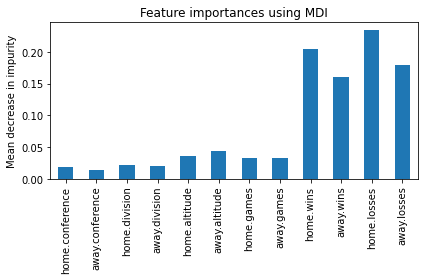

In [257]:
# Random Forest Classifier for 'winner_home'
rfc = RandomForestClassifier(n_estimators=100, criterion='gini', min_samples_split=2, min_samples_leaf=10, min_weight_fraction_leaf=0.0, max_features='auto', random_state=0)
rfc.fit(x_train.values, y_train['winner_home'].values)
rfcAccuracy = rfc.score(x_test.values, y_test['winner_home'].values)
print("Predicting: {}\nModel: {}\nAccuracy of: {}\n".format("winner_home", "Random Forest", rfcAccuracy))

show_feature_importance(rfc, features)

In [258]:
# LassoCV for predicated both teams scores
en1 = LassoCV()
en1.fit(x_train.values, y_train['home_points'].values)
en1Accuracy = en1.score(x_test.values, y_test['home_points'].values)

en2 = LassoCV()
en2.fit(x_train.values, y_train['away_points'].values)
en2Accuracy = en2.score(x_test.values, y_test['away_points'].values)

print("Predicting: {}\nModel: {}\nAccuracy: {}\n".format("home_points", "Lasso 1", en1Accuracy))
print("Predicting: {}\nModel: {}\nAccuracy: {}\n".format("away_points", "Lasso 2", en2Accuracy))

Predicting: home_points
Model: Lasso 1
Accuracy: 0.19216303662538659

Predicting: away_points
Model: Lasso 2
Accuracy: 0.32261660783472546



In [259]:
def prepare_data(homec, awayc, homed, awayd, homea, awaya, homeg, homew, homel, awayg, awayw, awayl):
  return {
      'home.conference' : convert_conference(homec),
      'away.conference' : convert_conference(awayc),
      'home.division' : convert_division(homed),
      'away.division' : convert_division(awayd),
      'home.altitude' : convert_wlt(homea),
      'away.altitude' : convert_wlt(awaya),
      'home.games' : convert_wlt(homeg),
      'away.games' : convert_wlt(awayg),
      'home.wins' : convert_wlt(homew),
      'away.wins' : convert_wlt(awayw),
      'home.losses' : convert_wlt(homel),
      'away.losses' : convert_wlt(awayl)
  }

In [276]:
# Bowl game data from games starting on 12/22/21 and onward
home_teams = ['Missouri', 'North Texas', 'UCF']
away_teams = ['Army', 'Miami OH', 'Florida']
missouri_army = prepare_data('SEC', 'FBS Independents', 'East', 'None', 199, 102, 12, 6, 6, 12, 8, 4)
northTexas_miamiOh = prepare_data('Conference USA', 'Mid-American', 'West', 'East', 196, 243, 12, 6, 6, 12, 6, 6)
ucf_florida = prepare_data('American', 'SEC', 'East', 'East', 17, 49, 12 ,8 ,4, 12, 6, 6)

bowl_games = [missouri_army, northTexas_miamiOh, ucf_florida]
bowl_df = pd.DataFrame.from_records(bowl_games)

In [277]:
for i in range(len(bowl_games)):
  bowl_game_features = bowl_df.iloc[i].values.reshape(1, -1)
  team = home_teams[i] if rfc.predict(bowl_game_features) else away_teams[i]
  home_score = en1.predict(bowl_game_features)
  away_score = en2.predict(bowl_game_features)
  print("Predicated: {}, with a score of -> {}: {} - {}: {}".format(team, home_teams[i], int(home_score[0]), away_teams[i], int(away_score[0])))

Predicated: Missouri, with a score of -> Missouri: 26 - Army: 28
Predicated: North Texas, with a score of -> North Texas: 28 - Miami OH: 25
Predicated: UCF, with a score of -> UCF: 32 - Florida: 22
